# AI Model Bias audit

Auditing an AI model that predicts age based on pictures for biases. The model evaluated was [dima806/fairface_age_image_detection](https://huggingface.co/dima806/fairface_age_image_detection).


In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setup
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)


## Dataset overview

The output labels of the model consist of age ranges in string format. The predicted_age column was calculated by taking the midpoint between the two values. e.g. The label "20-29" results in a predicted age of 24.5. For ages above 70, the model labels it as "more than 70". A value of 85 was taken to be the predicted age for this label.

In [40]:
# Read data
df = pd.read_csv("/kaggle/input/predicted-age-dataset-expanded/output-1.csv")

print("rows, cols:", df.shape)
print("\ncolumn dtypes:\n", df.dtypes)
print("\nfirst 5 rows:")
display(df.head())

rows, cols: (10135, 5)

column dtypes:
 filename          object
age                int64
gender            object
race              object
predicted_age    float64
dtype: object

first 5 rows:


,filename,age,gender,race,predicted_age
0,100_1_0_20170110183726390.jpg,100,female,White,85.0
1,100_1_2_20170105174847679.jpg,100,female,Asian,85.0
2,100_1_2_20170110182836729.jpg,100,female,Asian,85.0
3,101_1_2_20170105174739309.jpg,101,female,Asian,64.5
4,10_0_0_20161220222308131.jpg,10,male,White,6.0


In [41]:
### Add error columns

# 1. signed error
df['error'] = df['predicted_age'] - df['age']

# 2. absolute error
df['abs_error'] = df['error'].abs()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


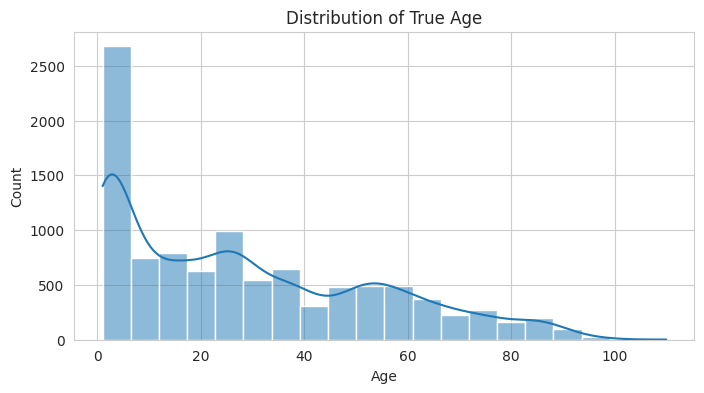

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


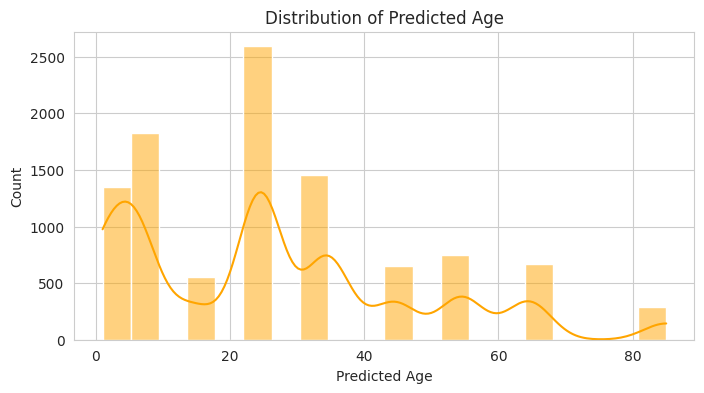

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


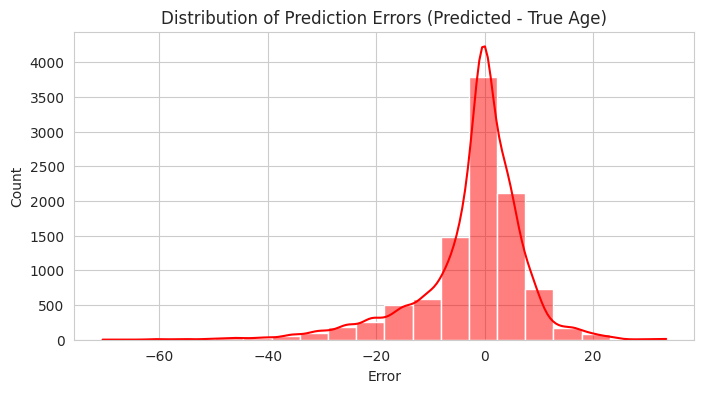

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


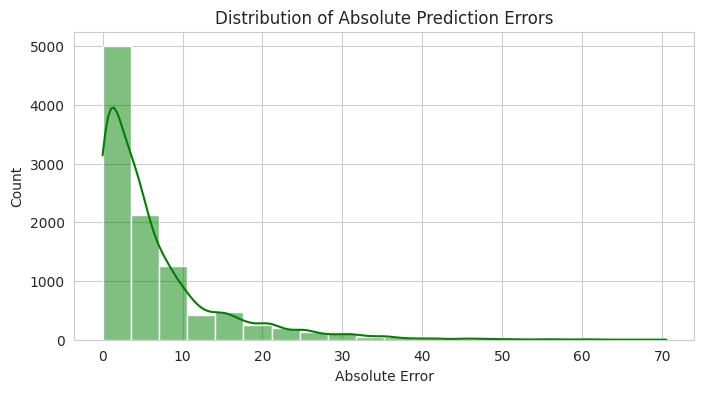

,age,predicted_age,error,abs_error
count,10135.000000,10135.000000,10135.000000,10135.000000
mean,28.883670,26.789837,-2.093833,6.394277
std,24.971683,21.268147,9.869080,7.803364
min,1.000000,1.000000,-70.500000,0.000000
25%,5.000000,6.000000,-4.500000,1.500000
50%,24.000000,24.500000,0.000000,4.000000
75%,49.000000,34.500000,3.500000,8.500000
max,110.000000,85.000000,33.500000,70.500000


In [42]:
# Distribution of True age
plt.figure(figsize=(8,4))
sns.histplot(df['age'], bins=20, kde=True)
plt.title("Distribution of True Age")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

# Distribution of predicted age
plt.figure(figsize=(8,4))
sns.histplot(df['predicted_age'], bins=20, kde=True, color='orange')
plt.title("Distribution of Predicted Age")
plt.xlabel("Predicted Age")
plt.ylabel("Count")
plt.show()

# Distribution of prediction errors
plt.figure(figsize=(8,4))
sns.histplot(df['error'], bins=20, kde=True, color='red')
plt.title("Distribution of Prediction Errors (Predicted - True Age)")
plt.xlabel("Error")
plt.ylabel("Count")
plt.show()

# Distribution of absolute errors
plt.figure(figsize=(8,4))
sns.histplot(df['abs_error'], bins=20, kde=True, color='green')
plt.title("Distribution of Absolute Prediction Errors")
plt.xlabel("Absolute Error")
plt.ylabel("Count")
plt.show()

display(df[['age','predicted_age','error','abs_error']].describe())

In [43]:
group_stats = (
    df.groupby(['gender', 'race'])
      .agg(mean_error=('error', 'mean'),
           median_error=('error', 'median'),
           mean_abs_error=('abs_error', 'mean'),
           median_abs_error=('abs_error', 'median'),
           count=('error', 'size'))
      .reset_index()
)
display(group_stats)

race_stats = (
    df.groupby(['race'])
      .agg(mean_error=('error', 'mean'),
           median_error=('error', 'median'),
           mean_abs_error=('abs_error', 'mean'),
           median_abs_error=('abs_error', 'median'),
           count=('error', 'size'))
      .reset_index()
)
display(race_stats)

gender_stats = (
    df.groupby(['gender'])
      .agg(mean_error=('error', 'mean'),
           median_error=('error', 'median'),
           mean_abs_error=('abs_error', 'mean'),
           median_abs_error=('abs_error', 'median'),
           count=('error', 'size'))
      .reset_index()
)
display(gender_stats)

,gender,race,mean_error,median_error,mean_abs_error,median_abs_error,count
0,female,Asian,-0.382060,0.0,4.146179,2.5,903
1,female,Black,-3.681818,-0.5,8.313397,5.0,209
2,female,Indian,-0.578307,0.0,4.840741,3.5,945
3,female,Other,0.805008,0.5,3.858118,2.5,659
4,female,White,-5.198437,-1.5,9.835938,6.5,2880
5,male,Asian,-0.385625,0.0,3.278125,1.0,800
6,male,Black,-2.793427,-0.5,8.511737,6.5,213
7,male,Indian,0.526460,0.0,3.787409,2.5,548
8,male,Other,0.309524,0.0,4.521645,3.5,462
9,male,White,-1.846979,-1.0,6.073132,4.0,2516


,race,mean_error,median_error,mean_abs_error,median_abs_error,count
0,Asian,-0.383735,0.0,3.738403,2.0,1703
1,Black,-3.233412,-0.5,8.413507,5.5,422
2,Indian,-0.172806,0.0,4.454119,3.5,1493
3,Other,0.600803,0.0,4.131579,2.5,1121
4,White,-3.635749,-1.5,8.081449,5.0,5396


,gender,mean_error,median_error,mean_abs_error,median_abs_error,count
0,female,-2.877412,0.0,7.313438,4.0,5596
1,male,-1.127781,0.0,5.261071,3.5,4539


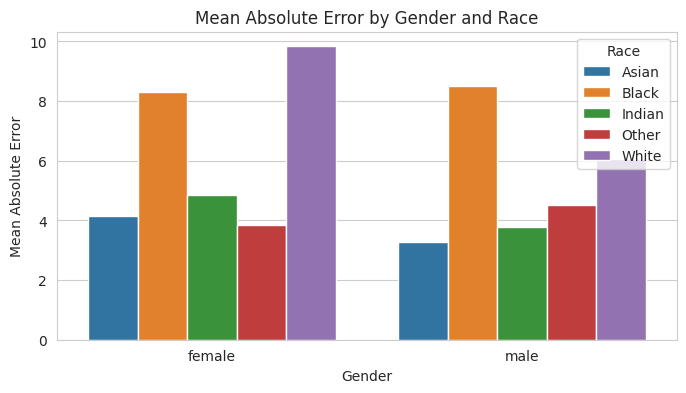

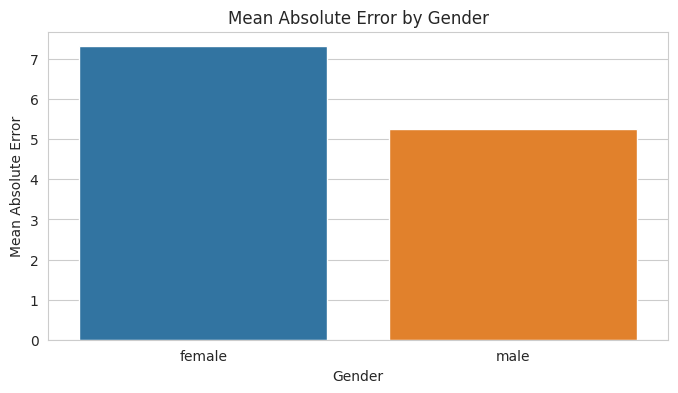

In [44]:
plt.figure(figsize=(8,4))
sns.barplot(data=group_stats, x='gender', y='mean_abs_error', hue='race')
plt.title("Mean Absolute Error by Gender and Race")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Gender")
plt.legend(title='Race')
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(data=gender_stats, x='gender', y='mean_abs_error')
plt.title("Mean Absolute Error by Gender")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Gender")
plt.show()

/tmp/ipykernel_37/159049080.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


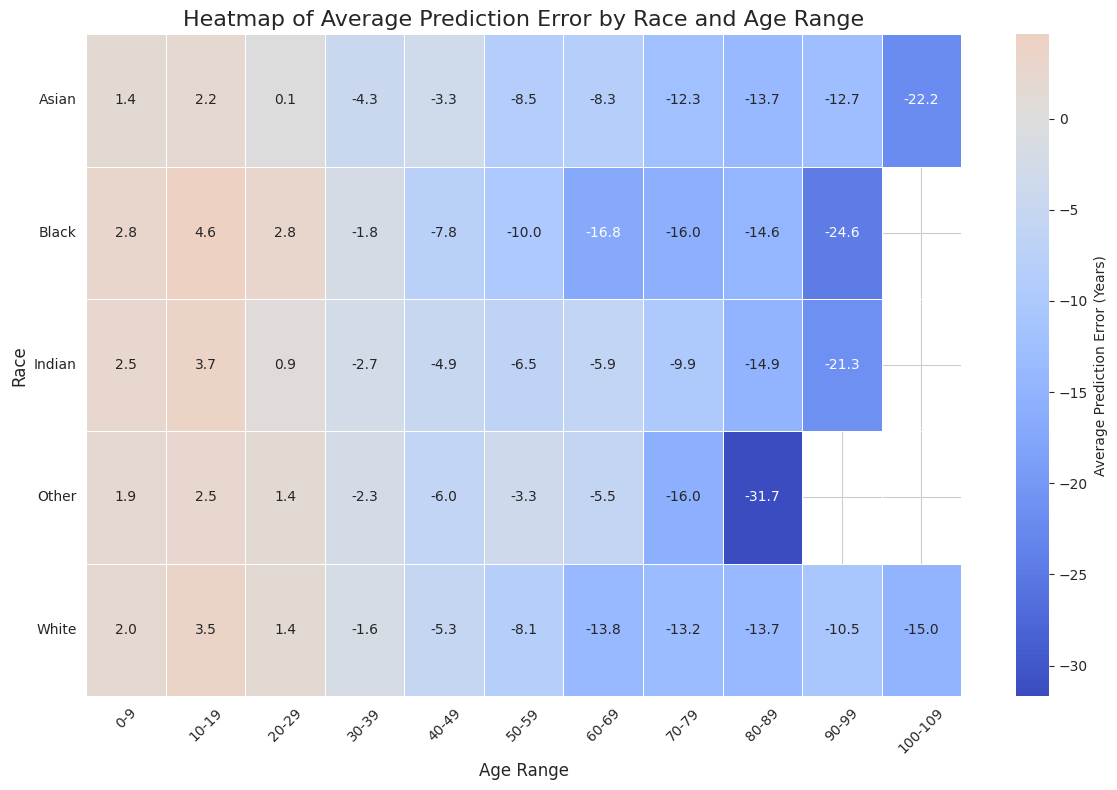

In [45]:
# --- 1. Prepare the Data: Create Age Bins ---

# Define the bin edges for age ranges (e.g., 0-9, 10-19, 20-29, etc.)
# We find the max age to ensure all data is included.
max_age = df['age'].max()
bins = range(0, max_age + 10, 10) # Bins of size 10

# Create labels for the bins for readability on the plot
labels = [f'{i}-{i+9}' for i in bins[:-1]]

# Use pd.cut to create a new column with these age ranges
df['age_range'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)


# --- 2. Create a Pivot Table for the Heatmap ---

# Group the data by race and the new age_range, then calculate the mean error.
# This creates a 2D matrix perfect for a heatmap.
heatmap_data = df.pivot_table(
    index='race',
    columns='age_range',
    values='error',  # Use the 'error' column to see bias direction
    aggfunc='mean'
)


# --- 3. Generate the Heatmap ---

plt.figure(figsize=(12, 8)) # Set the figure size for better readability

# Create the heatmap using seaborn
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',      # A diverging colormap is perfect for positive/negative errors
    center=0,             # Ensures 0 (no error) is the center color (e.g., white)
    annot=True,           # Write the data value in each cell
    fmt='.1f',            # Format the annotations to one decimal place
    linewidths=.5,        # Add lines between cells for clarity
    cbar_kws={'label': 'Average Prediction Error (Years)'} # Label the color bar
)

# Add titles and labels for clarity
plt.title('Heatmap of Average Prediction Error by Race and Age Range', fontsize=16)
plt.xlabel('Age Range', fontsize=12)
plt.ylabel('Race', fontsize=12)
plt.xticks(rotation=45) # Rotate x-axis labels if they overlap
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Display the plot
plt.show()

/tmp/ipykernel_37/2108418201.py:19: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = df.pivot_table(
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


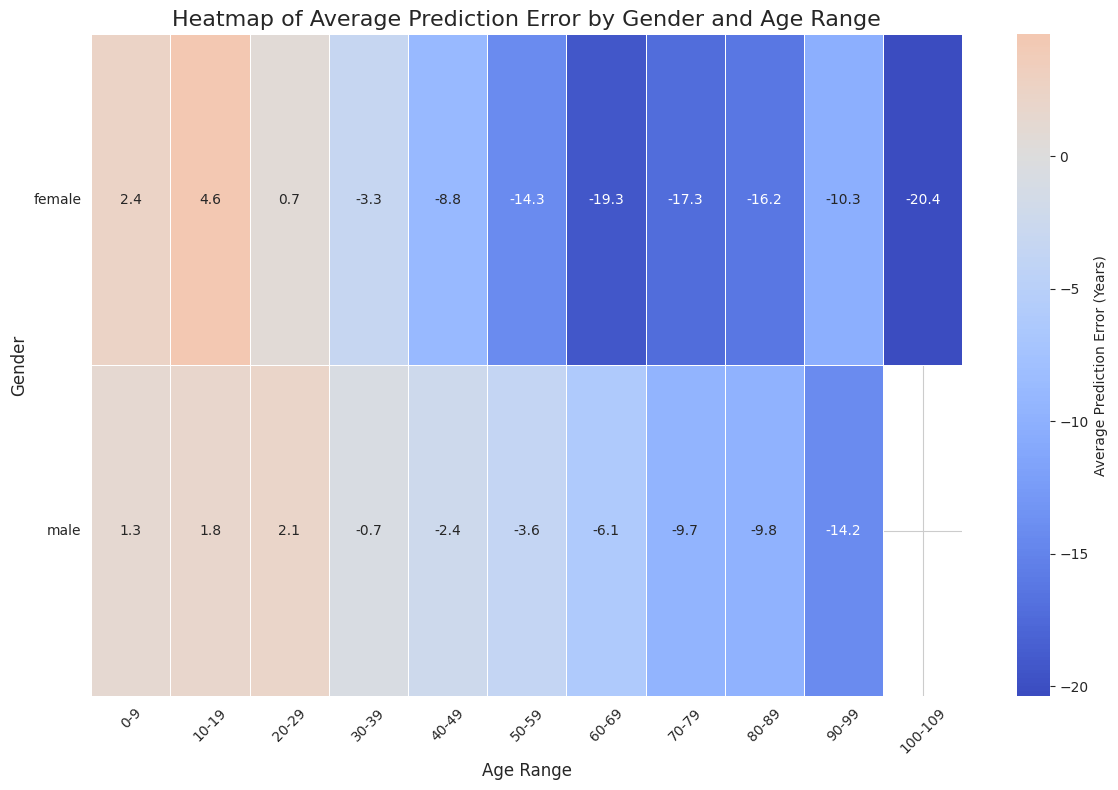

In [46]:
# --- 1. Prepare the Data: Create Age Bins ---

# Define the bin edges for age ranges (e.g., 0-9, 10-19, 20-29, etc.)
# We find the max age to ensure all data is included.
max_age = df['age'].max()
bins = range(0, max_age + 10, 10) # Bins of size 10

# Create labels for the bins for readability on the plot
labels = [f'{i}-{i+9}' for i in bins[:-1]]

# Use pd.cut to create a new column with these age ranges
df['age_range'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)


# --- 2. Create a Pivot Table for the Heatmap ---

# Group the data by race and the new age_range, then calculate the mean error.
# This creates a 2D matrix perfect for a heatmap.
heatmap_data = df.pivot_table(
    index='gender',
    columns='age_range',
    values='error',  # Use the 'error' column to see bias direction
    aggfunc='mean'
)


# --- 3. Generate the Heatmap ---

plt.figure(figsize=(12, 8)) # Set the figure size for better readability

# Create the heatmap using seaborn
sns.heatmap(
    heatmap_data,
    cmap='coolwarm',      # A diverging colormap is perfect for positive/negative errors
    center=0,             # Ensures 0 (no error) is the center color (e.g., white)
    annot=True,           # Write the data value in each cell
    fmt='.1f',            # Format the annotations to one decimal place
    linewidths=.5,        # Add lines between cells for clarity
    cbar_kws={'label': 'Average Prediction Error (Years)'} # Label the color bar
)

# Add titles and labels for clarity
plt.title('Heatmap of Average Prediction Error by Gender and Age Range', fontsize=16)
plt.xlabel('Age Range', fontsize=12)
plt.ylabel('Gender', fontsize=12)
plt.xticks(rotation=45) # Rotate x-axis labels if they overlap
plt.yticks(rotation=0)  # Keep y-axis labels horizontal

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Display the plot
plt.show()

In [47]:
# --- 1. Define the Error Threshold ---
# You can change this value to any number you are interested in.
# For example, this will find all predictions that were off by more than 15 years.
error_threshold = 20

# --- 2. Filter the DataFrame ---
# Create a boolean mask where the condition is True for rows to keep
# and False for rows to discard.
# We use the absolute error here to find predictions that are significantly
# off in either direction (over or under-prediction).
high_error_mask = df['abs_error'] > error_threshold

# Apply the mask to the DataFrame to get the subset of rows
high_error_rows = df[high_error_mask].reset_index()

# --- 3. Display the Results ---

# Check if any rows were found before trying to display them
if not high_error_rows.empty:
    print(f"Displaying {len(high_error_rows)} rows where the absolute error is above {error_threshold} years:")
    print(high_error_rows)
else:
    print(f"No rows found with an absolute error above {error_threshold} years.")


Displaying 718 rows where the absolute error is above 20 years:
     index                       filename  age  gender    race  predicted_age  error  abs_error age_range
0        3  101_1_2_20170105174739309.jpg  101  female   Asian           64.5  -36.5       36.5   100-109
1      140   10_1_3_20170109203848078.jpg   10  female  Indian           34.5   24.5       24.5     10-19
2      146  110_1_1_20170110155117522.jpg  110  female   Black           85.0  -25.0       25.0       NaN
3      147  110_1_1_20170110155201038.jpg  110  female   Black           85.0  -25.0       25.0       NaN
4      148  110_1_3_20170110155139762.jpg  110  female  Indian           85.0  -25.0       25.0       NaN
..     ...                            ...  ...     ...     ...            ...    ...        ...       ...
713   9932   92_0_0_20170111223719595.jpg   92    male   White           64.5  -27.5       27.5     90-99
714   9933   92_0_2_20170105174832245.jpg   92    male   Asian           64.5  -27.5    

--- Systematic Bias (Mean Error) for Each Group ---
     race  gender  systematic_bias
0   Asian  female        -0.382060
1   Asian    male        -0.385625
2   Black  female        -3.681818
3   Black    male        -2.793427
4  Indian  female        -0.578307
5  Indian    male         0.526460
6   Other  female         0.805008
7   Other    male         0.309524
8   White  female        -5.198437
9   White    male        -1.846979


--- Correction Factor to be Applied for Each Group ---
     race  gender  correction_factor
0   Asian  female           0.382060
1   Asian    male           0.385625
2   Black  female           3.681818
3   Black    male           2.793427
4  Indian  female           0.578307
5  Indian    male          -0.526460
6   Other  female          -0.805008
7   Other    male          -0.309524
8   White  female           5.198437
9   White    male           1.846979


--- DataFrame with Adjusted Predictions (showing first 5 rows) ---
                        filena

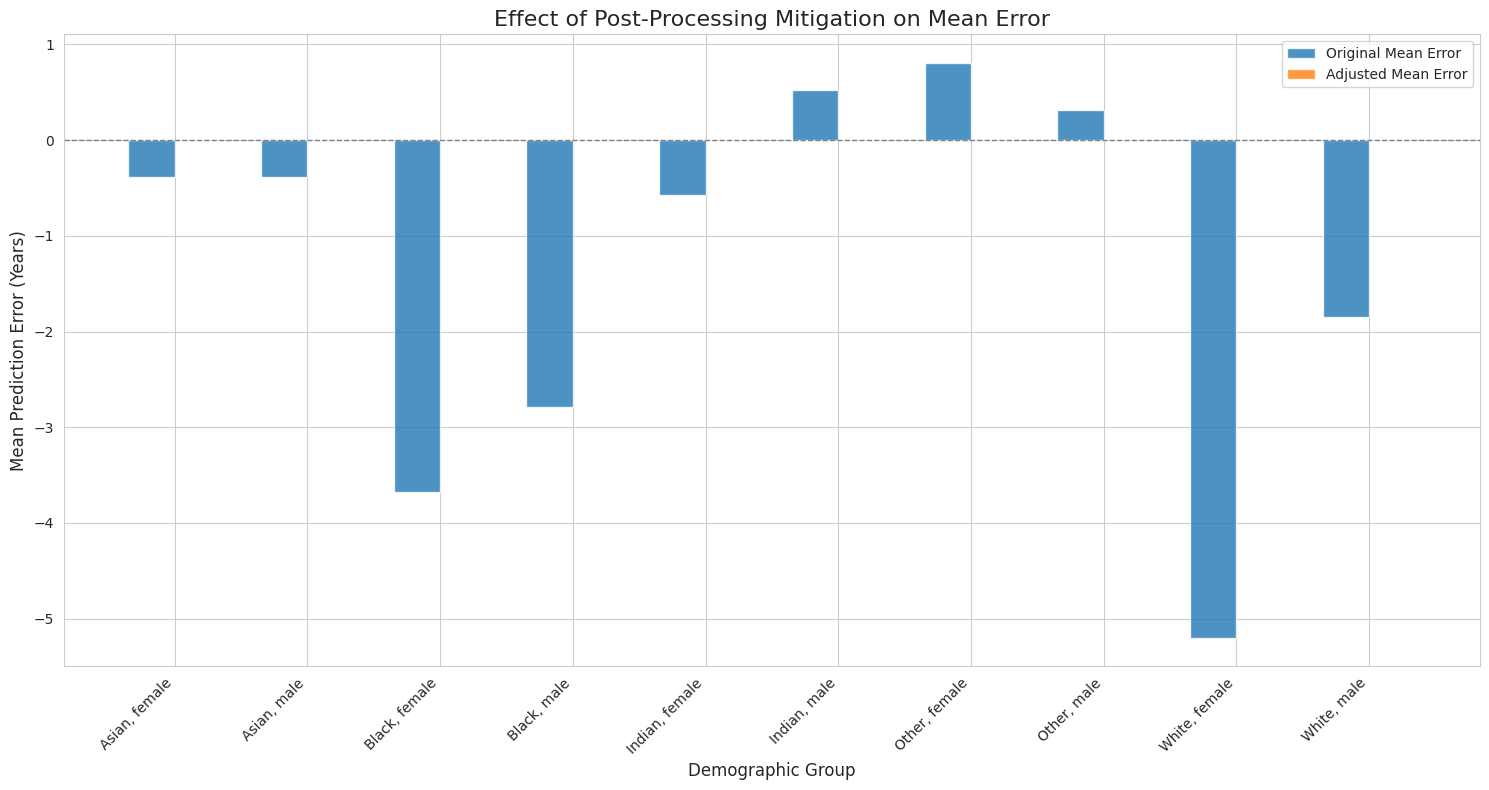

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assume df is your DataFrame with predictions and errors already calculated ---

# ==============================================================================
# 1. CALCULATE THE SYSTEMATIC BIAS FOR EACH DEMOGRAPHIC GROUP
# ==============================================================================

# Group by race and gender, then calculate the mean error for each group.
# This mean error represents the systematic bias (e.g., consistently over/under-predicting).
group_bias = df.groupby(['race', 'gender'])['error'].mean().reset_index()
group_bias.rename(columns={'error': 'systematic_bias'}, inplace=True)

print("--- Systematic Bias (Mean Error) for Each Group ---")
print(group_bias)
print("\n")


# ==============================================================================
# 2. APPLY THE CORRECTION TO THE PREDICTIONS
# ==============================================================================

# To correct the predictions, we need to subtract the systematic bias.
# For example, if the mean error is +2.5 (overestimation), we subtract 2.5.
# The correction factor is simply the negative of the bias.
group_bias['correction_factor'] = -group_bias['systematic_bias']

print("--- Correction Factor to be Applied for Each Group ---")
print(group_bias[['race', 'gender', 'correction_factor']])
print("\n")


# Merge the correction factors back into the main DataFrame.
# This adds a 'correction_factor' column to every row based on its race and gender.
df_adjusted = pd.merge(
    df,
    group_bias[['race', 'gender', 'correction_factor']],
    on=['race', 'gender'],
    how='left'
)

# Create a new column with the adjusted predictions.
# We add the correction factor (which is the negative of the bias).
df_adjusted['adjusted_predicted_age'] = df_adjusted['predicted_age'] + df_adjusted['correction_factor']

# Calculate the new error after adjustment
df_adjusted['adjusted_error'] = df_adjusted['adjusted_predicted_age'] - df_adjusted['age']

print("--- DataFrame with Adjusted Predictions (showing first 5 rows) ---")
print(df_adjusted.head())
print("\n")


# ==============================================================================
# 3. VERIFY THE EFFECTIVENESS OF THE MITIGATION
# ==============================================================================

# Calculate the new average error for each group after adjustment
new_group_bias = df_adjusted.groupby(['race', 'gender'])['adjusted_error'].mean().reset_index()
new_group_bias.rename(columns={'adjusted_error': 'new_mean_error'}, inplace=True)

# Merge original and new biases for comparison
comparison = pd.merge(
    group_bias[['race', 'gender', 'systematic_bias']],
    new_group_bias,
    on=['race', 'gender']
)
comparison['group'] = comparison['race'] + ', ' + comparison['gender']

# Plot the comparison to visualize the improvement
plt.figure(figsize=(15, 8))
bar_width = 0.35
index = np.arange(len(comparison))

plt.bar(index, comparison['systematic_bias'], bar_width, label='Original Mean Error', alpha=0.8)
plt.bar(index + bar_width, comparison['new_mean_error'], bar_width, label='Adjusted Mean Error', alpha=0.8)

plt.axhline(0, color='grey', linestyle='--', linewidth=1) # Add a line at y=0 for reference

plt.xlabel('Demographic Group', fontsize=12)
plt.ylabel('Mean Prediction Error (Years)', fontsize=12)
plt.title('Effect of Post-Processing Mitigation on Mean Error', fontsize=16)
plt.xticks(index + bar_width / 2, comparison['group'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# The DataFrame 'df_adjusted' now contains the mitigated predictions in the 'adjusted_predicted_age' column.